# Illustrating the results

Import everything necessary

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import scipy
import seaborn
from tqdm import tqdm
import yfinance as yf
from scipy.stats import norm
from optimization_functions import *
from results_functions import *
%load_ext autoreload
%autoreload 2
%aimport optimization_functions
%aimport results_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the trained neural networks

The number of trained periods

In [43]:
T=10

The considered stocks

In [44]:
stocks = ["GOOGL","EBAY","AMZN","MSFT","AAPL"]

Create empty dictionaries

In [45]:
Returns_train_tf_dict = {}
Returns_test1_tf_dict = {}
Returns_test2_tf_dict = {}
S_train_dict = {}
S_test1_dict = {}
S_test2_dict = {}

Create training and test periods

In [46]:
for s in stocks:
    S_train = yf.download(s, start="2010-01-02", end="2020-02-01")
    S_train = S_train.dropna()
    S_train = S_train.reset_index()
    S_train = S_train[["Date","Close"]]
    S_train_dict[s] = S_train
    
    Returns_train = S_train["Close"].diff() / S_train["Close"].shift(1)
    Returns_train = Returns_train.dropna()
    # A Tensorflow Adaption
    Returns_train_tf_dict[s] = tf.reshape(Returns_train,(1,len(Returns_train)))

    S_test1 = yf.download(s, start="2020-02-01", end="2020-04-16")
    S_test1 = S_test1.dropna()
    S_test1 = S_test1.reset_index()
    S_test1 = S_test1[["Date","Close"]]
    S_test1_dict[s] = S_test1
    
    Returns_test1 = S_test1["Close"].diff() / S_test1["Close"].shift(1)
    Returns_test1 = Returns_test1.dropna()
    # A Tensorflow Adaption
    Returns_test1_tf_dict[s]  = tf.reshape(Returns_test1,(1,len(Returns_test1)))
    
    S_test2 = yf.download(s, start="2020-04-16", end="2020-06-29")
    S_test2 = S_test2.dropna()
    S_test2 = S_test2.reset_index()
    S_test2 = S_test2[["Date","Close"]]
    S_test2_dict[s] = S_test2

    Returns_test2 = S_test2["Close"].diff() / S_test2["Close"].shift(1)
    Returns_test2= Returns_test2.dropna()
    # A Tensorflow Adaption
    Returns_test2_tf_dict[s]  = tf.reshape(Returns_test2,(1,len(Returns_test2)))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Load the trained strategies

In [47]:
a_tilde_dict = {}
a_tilde_robust_0005_dict = {}
a_tilde_robust_0001_dict = {}
a_tilde_adaptive_dict = {}

for s in stocks: 
    a_tilde_dict[s] = file_load(s,"Non-Robust",T)
    a_tilde_robust_0001_dict[s] = file_load(s,"Robust_0001",T)
    a_tilde_robust_0005_dict[s] = file_load(s,"Robust_0005",T)
    a_tilde_adaptive_dict[s] =  file_load(s,"Robust_adaptive",T)

Depict Training and Testing Periods

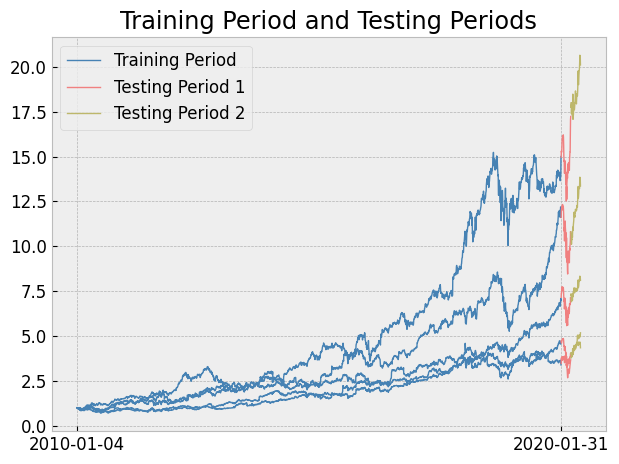

In [48]:
matplotlib.rcParams.update({'font.size': 12})

for s in stocks: 
    S0 = S_train_dict[s]["Close"].iloc[0]
    plt.plot(range(len(S_train_dict[s])),
             S_train_dict[s]["Close"]/S0,label="Training Period",color="steelblue", linewidth=1)
    plt.plot(range(len(S_train_dict[s]),len(S_train_dict[s])+len(S_test1_dict[s])),
             S_test1_dict[s]["Close"]/S0,label="Testing Period 1",color="lightcoral", linewidth=1)
    plt.plot(range(len(S_train_dict[s])+len(S_test1_dict[s]),len(S_train_dict[s])+len(S_test1_dict[s])+len(S_test2_dict[s])),
             S_test2_dict[s]["Close"]/S0,label="Testing Period 2",color="darkkhaki", linewidth=1)
    plt.title("Training Period and Testing Periods")
    
xtick_numbers1 = [0,len(S_train_dict[s])] #,len(S_train)+len(S_test1),len(S_train)+len(S_test1)+len(S_test2)]
plt.xticks(xtick_numbers1, [S_train_dict[s]["Date"].dt.date.iloc[xtick_numbers1[0]],S_train_dict[s]["Date"].dt.date.iloc[xtick_numbers1[1]-1]] )#,S_test1["Date"].dt.date.iloc[0],S_test2["Date"].dt.date.iloc[0]])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:3], labels[:3])  # Only keep the first three elements
plt.grid(True)
plt.tight_layout()
plt.savefig('portfolio_train_test_split.pdf', format='pdf')
plt.show()

The estimated covariance matrix, based on training data

In [49]:
cov = estimate_covariance_matrix(np.transpose(tf.concat([Returns_train_tf_dict[s] for s in stocks],axis = 0)))

if len(stocks) == 1:
    cov = np.reshape(cov,(1,1))

cov

array([[0.00023442, 0.00011647, 0.00016578, 0.00011755, 0.00011557],
       [0.00011647, 0.00031847, 0.00013813, 0.00010943, 0.00010243],
       [0.00016578, 0.00013813, 0.00038073, 0.00013553, 0.00012419],
       [0.00011755, 0.00010943, 0.00013553, 0.00020457, 0.00010672],
       [0.00011557, 0.00010243, 0.00012419, 0.00010672, 0.00026344]])

# Evaluation

# 1) Evaluation on Training Data

In [50]:
df_merged_1_dict = {}
Rewards_1_dict = {}
Rewards_robust_1_dict = {}
Rewards_robust_12_dict = {}
Rewards_robust_adaptive_1_dict = {}
Rewards_BS_1_dict = {}

i = 0
for s in stocks:
    d1,r1,r2,r3,r4,r5 = evaluate_nn(Returns_train_tf_dict[s][:,:50],
                                       a_tilde_dict[s],
                                       a_tilde_robust_0001_dict[s],
                                       a_tilde_robust_0005_dict[s],
                                        a_tilde_adaptive_dict[s],T,vol = np.sqrt(cov[i][i]))
    # Assignment of the results
    df_merged_1_dict[s] = d1
    Rewards_1_dict[s] = r1
    Rewards_robust_1_dict[s] = r2
    Rewards_robust_12_dict[s] = r3
    Rewards_robust_adaptive_1_dict[s] = r4
    Rewards_BS_1_dict[s] = r5
    i += 1
    
if len(stocks)>1:
    # Merge all DataFrames in df_merged_1_dict into one
    df_combined_1 = pd.concat(df_merged_1_dict.values(), keys=df_merged_1_dict.keys(), names=["Stock", "Index"])
    
    # Reset index if necessary
    print(df_combined_1.groupby(level="Stock").describe().transpose())
    
    # Display the merged DataFrame
    df_combined_1.round(4).describe()
else:
    df_merged_1_dict[s].round(4).describe()

100%|██████████| 40/40 [01:25<00:00,  2.13s/it]

Stock                            AAPL       AMZN       EBAY      GOOGL  \
Non-Robust           count  40.000000  40.000000  40.000000  40.000000   
                     mean    0.109608   0.083091   0.090285   0.058983   
                     std     0.109551   0.059718   0.069826   0.053056   
                     min     0.004915   0.006670   0.004035   0.008174   
                     25%     0.026954   0.036658   0.030004   0.029086   
                     50%     0.076034   0.076094   0.081649   0.048886   
                     75%     0.137065   0.106394   0.131863   0.063552   
                     max     0.377962   0.298024   0.255258   0.289099   
Robust, eps = 0.0001 count  40.000000  40.000000  40.000000  40.000000   
                     mean    0.085420   0.090262   0.092485   0.071125   
                     std     0.076496   0.076264   0.066549   0.076180   
                     min     0.002964   0.006024   0.007823   0.002413   
                     25%     0.034266 

# Overall Statistics

In [51]:
df_all_1 = df_combined_1.reset_index()
df_all_1.describe()

,Index,Non-Robust,"Robust, eps = 0.0001","Robust, eps = 0.0005",Robust adaptive,Black-Scholes
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,19.500000,0.078061,0.075544,0.073260,0.088340,0.075122
std,11.572364,0.073029,0.069559,0.061118,0.075442,0.060174
min,0.000000,0.001360,0.002043,0.000266,0.001341,0.006464
25%,9.750000,0.028395,0.029133,0.031251,0.034776,0.032818
50%,19.500000,0.055868,0.055753,0.058457,0.068850,0.058468
75%,29.250000,0.096489,0.089705,0.092518,0.117239,0.097687
max,39.000000,0.377962,0.339487,0.326295,0.368458,0.315949


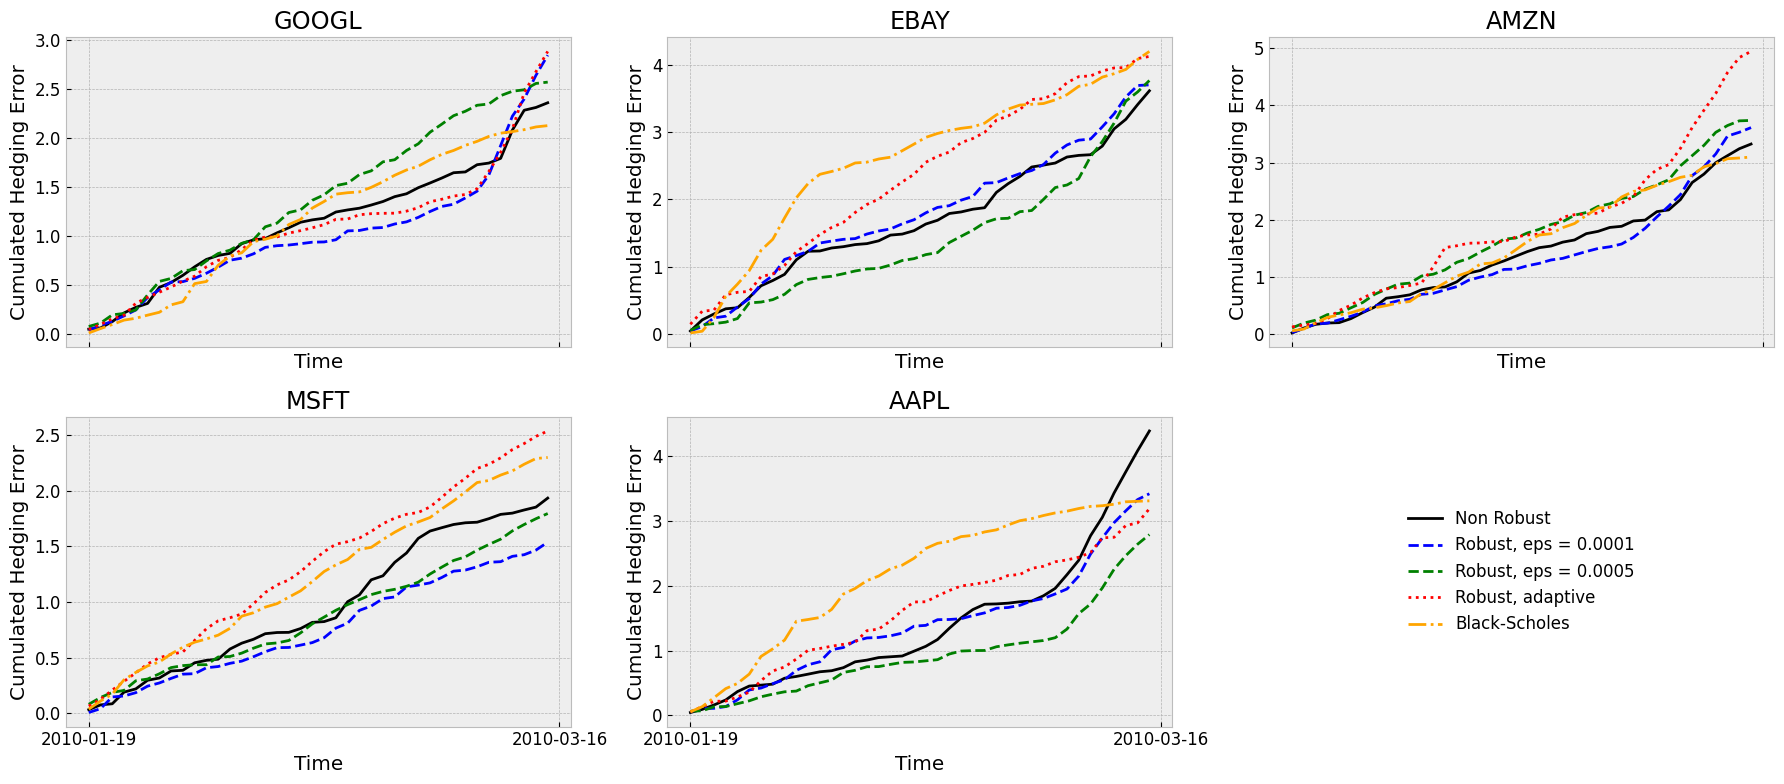

In [52]:
# Define the number of stocks
num_stocks = len(stocks)

# Determine the number of rows and columns for the subplots
num_cols = (num_stocks + 1) // 2  # Distribute stocks into two rows
num_rows = 2 if num_stocks > 1 else 1


# Create subplots and adjust the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6* num_cols, 4 * num_rows), sharex=True)

# Flatten axes for easier iteration, but keep the 2D shape for positioning the legend
axes = np.array(axes).reshape(num_rows, num_cols)

plt.subplots_adjust(left=0.1)  # Adjust left margin to make space

# Variable to store the handles and labels for the legend
handles, labels = [], []

# Iterate through stocks and plot them in the subplots
for idx, (ax, s) in enumerate(zip(axes.flatten(), stocks)):
    ax.set_title(f"{s}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated Hedging Error")
    line1, = ax.plot(np.cumsum(Rewards_1_dict[s]), color="black", label="Non Robust")
    line2, = ax.plot(np.cumsum(Rewards_robust_1_dict[s]), color="blue", label="Robust, eps = 0.0001", linestyle="dashed")
    line3, = ax.plot(np.cumsum(Rewards_robust_12_dict[s]), color="green", label="Robust, eps = 0.0005", linestyle="dashed")
    line4, = ax.plot(np.cumsum(Rewards_robust_adaptive_1_dict[s]), color="red", label="Robust, adaptive", linestyle="dotted")
    line5, = ax.plot(np.cumsum(Rewards_BS_1_dict[s]), color="orange", label="Black-Scholes", linestyle="dashdot")

    # Store handles and labels only once
    if not handles and not labels:
        handles.extend([line1, line2, line3, line4, line5])
        labels.extend([line.get_label() for line in [line1, line2, line3, line4, line5]])

    xtick_numbers_train = [0, len(Rewards_1_dict[s])]
    ax.set_xticks(xtick_numbers_train)
    ax.set_xticklabels([
        S_train["Date"].dt.date.iloc[xtick_numbers_train[0]+T],
        S_train["Date"].dt.date.iloc[xtick_numbers_train[1] - 1+T]
    ])

    ax.grid(True)

# Place the legend in the last subplot of the second row
legend_ax = axes[-1, -1]  # Last column of the second row
legend_ax.axis('off')  # Hide the axes
legend_ax.legend(handles, labels, loc='center', frameon=False)  # Place legend in center



# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 1])  # Ensure the main plot area is optimized

plt.show()


# 2) Evaluation in Testing Period 1

In [53]:
df_merged_2_dict = {}
Rewards_2_dict = {}
Rewards_robust_2_dict = {}
Rewards_robust_22_dict = {}
Rewards_robust_adaptive_2_dict = {}
Rewards_BS_2_dict = {}

i = 0
for s in stocks:
    d1,r1,r2,r3,r4,r5 = evaluate_nn(Returns_test1_tf_dict[s][:,:],
                                       a_tilde_dict[s],
                                       a_tilde_robust_0001_dict[s],
                                       a_tilde_robust_0005_dict[s],
                                        a_tilde_adaptive_dict[s],T,vol = np.sqrt(cov[i][i]))
    # Assignment of the results
    df_merged_2_dict[s] = d1
    Rewards_2_dict[s] = r1
    Rewards_robust_2_dict[s] = r2
    Rewards_robust_22_dict[s] = r3
    Rewards_robust_adaptive_2_dict[s] = r4
    Rewards_BS_2_dict[s] = r5
    i+= 1
    
if len(stocks)>1:
    # Merge all DataFrames in df_merged_1_dict into one
    df_combined_2 = pd.concat(df_merged_2_dict.values(), keys=df_merged_2_dict.keys(), names=["Stock", "Index"])
    
    # Reset index if necessary
    print(df_combined_2.groupby(level="Stock").describe().transpose())
    
    # Display the merged DataFrame
    df_combined_2.round(4).describe()
else:
    df_merged_2_dict[s].round(4).describe()

100%|██████████| 40/40 [01:02<00:00,  1.57s/it]

Stock                            AAPL       AMZN       EBAY      GOOGL  \
Non-Robust           count  40.000000  40.000000  40.000000  40.000000   
                     mean    0.129477   0.109242   0.130238   0.146678   
                     std     0.092596   0.097726   0.114032   0.139459   
                     min     0.006430   0.001114   0.013851   0.013595   
                     25%     0.076175   0.046189   0.049635   0.039822   
                     50%     0.104542   0.081872   0.094608   0.129559   
                     75%     0.156385   0.120563   0.166793   0.187543   
                     max     0.379953   0.522963   0.521170   0.662705   
Robust, eps = 0.0001 count  40.000000  40.000000  40.000000  40.000000   
                     mean    0.122357   0.119581   0.119685   0.115377   
                     std     0.093927   0.090361   0.106942   0.096483   
                     min     0.002509   0.013791   0.002342   0.003660   
                     25%     0.058730 

# Average Statistics

In [54]:
df_all_2 = df_combined_2.reset_index()
df_all_2.describe()

,Index,Non-Robust,"Robust, eps = 0.0001","Robust, eps = 0.0005",Robust adaptive,Black-Scholes
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,19.500000,0.142130,0.135642,0.118353,0.142117,0.149360
std,11.572364,0.122850,0.121028,0.103237,0.125273,0.132188
min,0.000000,0.001114,0.002342,0.000605,0.000754,0.009147
25%,9.750000,0.054409,0.048086,0.041024,0.055143,0.057429
50%,19.500000,0.102522,0.098509,0.091600,0.104539,0.107664
75%,29.250000,0.194450,0.180385,0.164017,0.178010,0.189006
max,39.000000,0.707205,0.799624,0.513488,0.663914,0.700164


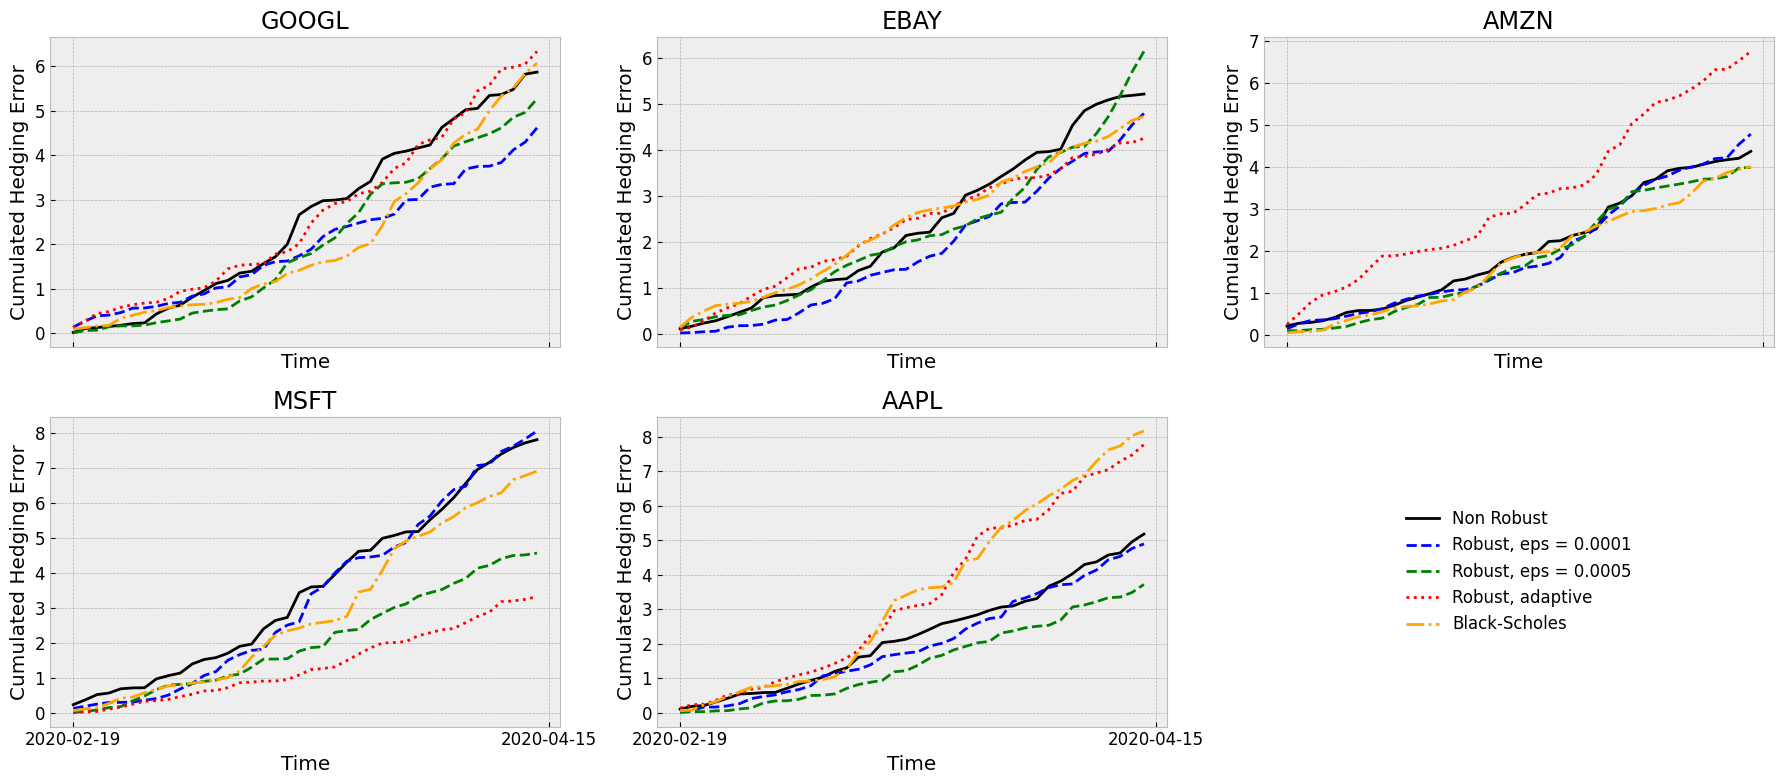

In [63]:
# Define the number of stocks
num_stocks = len(stocks)

# Determine the number of rows and columns for the subplots
num_cols = (num_stocks + 1) // 2  # Distribute stocks into two rows
num_rows = 2 if num_stocks > 1 else 1


# Create subplots and adjust the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6* num_cols, 4 * num_rows), sharex=True)

# Flatten axes for easier iteration, but keep the 2D shape for positioning the legend
axes = np.array(axes).reshape(num_rows, num_cols)

plt.subplots_adjust(left=0.1)  # Adjust left margin to make space

# Variable to store the handles and labels for the legend
handles, labels = [], []

# Iterate through stocks and plot them in the subplots
for idx, (ax, s) in enumerate(zip(axes.flatten(), stocks)):
    ax.set_title(f"{s}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated Hedging Error")
    line1, = ax.plot(np.cumsum(Rewards_2_dict[s]), color="black", label="Non Robust")
    line2, = ax.plot(np.cumsum(Rewards_robust_2_dict[s]), color="blue", label="Robust, eps = 0.0001", linestyle="dashed")
    line3, = ax.plot(np.cumsum(Rewards_robust_22_dict[s]), color="green", label="Robust, eps = 0.0005", linestyle="dashed")
    line4, = ax.plot(np.cumsum(Rewards_robust_adaptive_2_dict[s]), color="red", label="Robust, adaptive", linestyle="dotted")
    line5, = ax.plot(np.cumsum(Rewards_BS_2_dict[s]), color="orange", label="Black-Scholes", linestyle="dashdot")
    
    # Store handles and labels only once
    if not handles and not labels:
        handles.extend([line1, line2, line3, line4,line5])
        labels.extend([line.get_label() for line in [line1, line2, line3, line4,line5]])

    xtick_numbers_test1 = [0, len(Rewards_2_dict[s])]
    ax.set_xticks(xtick_numbers_test1)
    ax.set_xticklabels([
        S_test1["Date"].dt.date.iloc[xtick_numbers_test1[0]+T+1],
        S_test1["Date"].dt.date.iloc[xtick_numbers_test1[1] +T]
    ])

    ax.grid(True)

# Place the legend in the last subplot of the second row
legend_ax = axes[-1, -1]  # Last column of the second row
legend_ax.axis('off')  # Hide the axes
legend_ax.legend(handles, labels, loc='center', frameon=False)  # Place legend in center



# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 1])  # Ensure the main plot area is optimized
plt.savefig('test1.pdf', format='pdf')
plt.show()


### Histograms

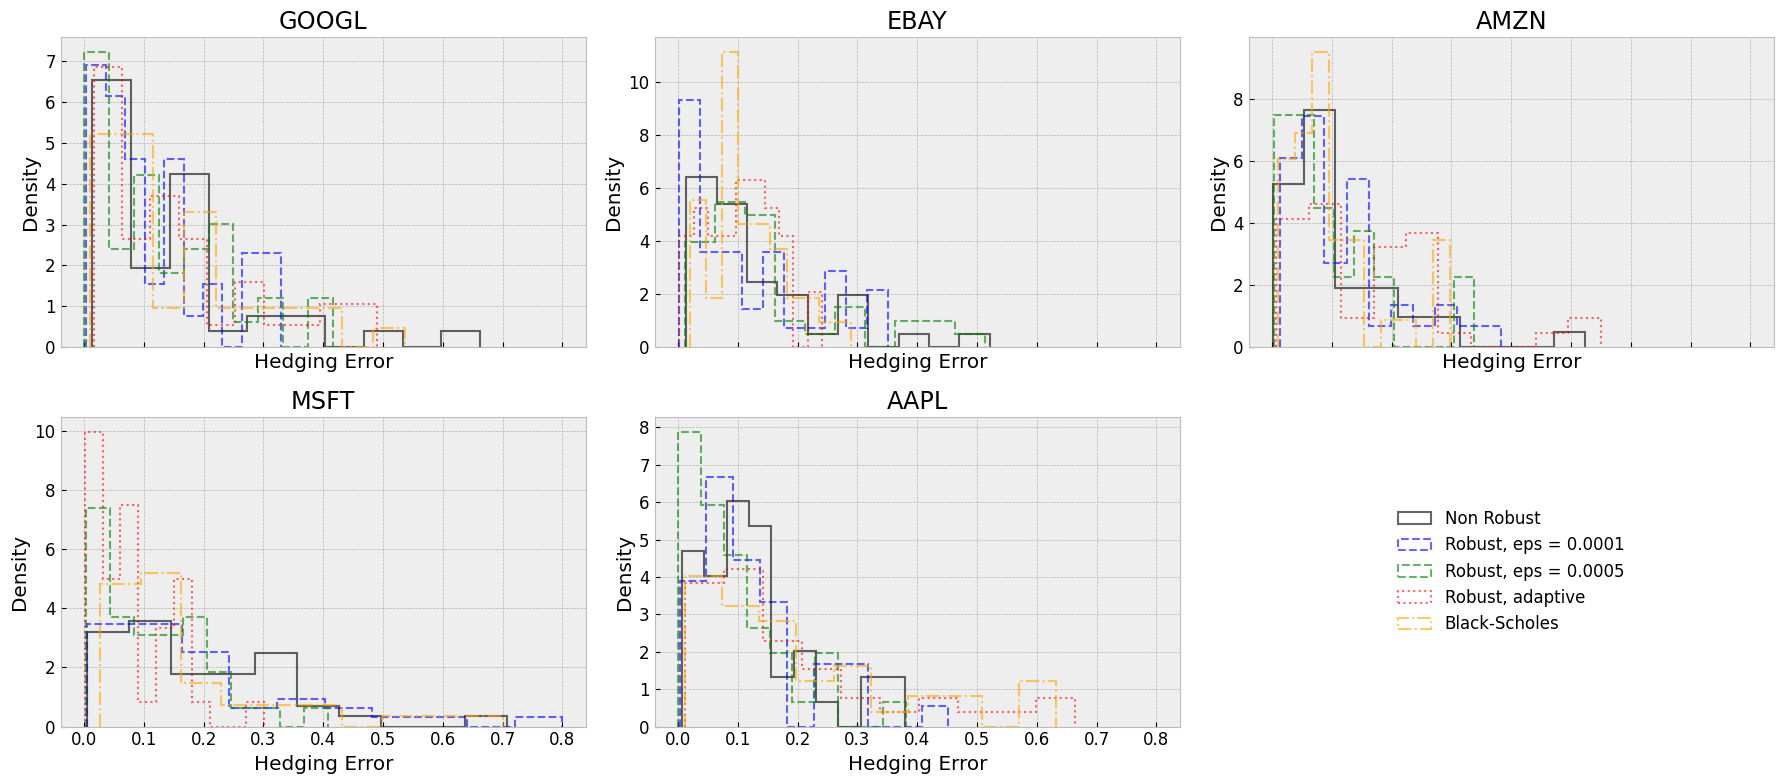

In [56]:
# Define the number of stocks
num_stocks = len(stocks)

# Determine the number of rows and columns for the subplots
num_cols = (num_stocks + 1) // 2  # Distribute stocks into two rows
num_rows = 2 if num_stocks > 1 else 1

# Create subplots and adjust the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows), sharex=True)

# Flatten axes for easier iteration, but keep the 2D shape for positioning the legend
axes = np.array(axes).reshape(num_rows, num_cols)

plt.subplots_adjust(left=0.1)

# Iterate through stocks and plot them in the subplots
for idx, (ax, s) in enumerate(zip(axes.flatten(), stocks)):
    ax.set_title(f"{s}")
    ax.set_xlabel("Hedging Error")
    ax.set_ylabel("Density")
    h1 = ax.hist(Rewards_2_dict[s], color="black", histtype='step', linewidth=1.5,label="Non Robust", alpha=0.6, density=True)
    h2 = ax.hist(Rewards_robust_2_dict[s], color="blue", histtype='step', linewidth=1.5,label="Robust, eps = 0.0001", linestyle="dashed", alpha=0.6, density=True)
    h3 = ax.hist(Rewards_robust_22_dict[s], color="green", histtype='step', linewidth=1.5, label="Robust, eps = 0.0005", linestyle="dashed", alpha=0.6, density=True)
    h4 = ax.hist(Rewards_robust_adaptive_2_dict[s], color="red", histtype='step', linewidth=1.5, label="Robust, adaptive", linestyle="dotted", alpha=0.6, density=True)
    h5 = ax.hist(Rewards_BS_2_dict[s], color="orange", histtype='step', linewidth=1.5, label="Black-Scholes", linestyle="dashdot", alpha=0.6, density=True)
    ax.grid(True)

# Collect handles and labels from any subplot (e.g., first)
handles, labels = axes[0, 0].get_legend_handles_labels()

# Determine the subplot location for the legend: second row, third column
# Ensure there are enough columns
if num_rows >= 2 and num_cols >= 3:
    legend_ax = axes[1, 2]
else:
    legend_ax = axes[-1, -1]  # fallback: last subplot

legend_ax.axis('off')
legend_ax.legend(handles, labels, loc='center', frameon=False)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('histogram_test1.pdf', format='pdf')
plt.show()


# 3) Evaluation in Testing Period 2


In [57]:
df_merged_3_dict = {}
Rewards_3_dict = {}
Rewards_robust_3_dict = {}
Rewards_robust_32_dict = {}
Rewards_robust_adaptive_3_dict = {}
Rewards_BS_3_dict = {}

i = 0
for s in stocks:
    d1,r1,r2,r3,r4,r5 = evaluate_nn(Returns_test2_tf_dict[s][:,:],
                                       a_tilde_dict[s],
                                       a_tilde_robust_0001_dict[s],
                                       a_tilde_robust_0005_dict[s],
                                        a_tilde_adaptive_dict[s],T,vol = np.sqrt(cov[i][i]))
    # Assignment of the results
    df_merged_3_dict[s] = d1
    Rewards_3_dict[s] = r1
    Rewards_robust_3_dict[s] = r2
    Rewards_robust_32_dict[s] = r3
    Rewards_robust_adaptive_3_dict[s] = r4
    Rewards_BS_3_dict[s] = r5
    i+= 1
    
if len(stocks)>1:
    # Merge all DataFrames in df_merged_1_dict into one
    df_combined_3 = pd.concat(df_merged_3_dict.values(), keys=df_merged_3_dict.keys(), names=["Stock", "Index"])
    
    # Reset index if necessary
    print(df_combined_3.groupby(level="Stock").describe().transpose())
    
    # Display the merged DataFrame
    df_combined_3.round(4).describe()
else:
    df_merged_3_dict[s].round(4).describe()

100%|██████████| 40/40 [01:15<00:00,  1.90s/it]

Stock                            AAPL       AMZN       EBAY      GOOGL  \
Non-Robust           count  40.000000  40.000000  40.000000  40.000000   
                     mean    0.172019   0.053425   0.116084   0.089079   
                     std     0.097492   0.042129   0.099302   0.101841   
                     min     0.008983   0.001924   0.004117   0.002882   
                     25%     0.107985   0.022197   0.036923   0.031323   
                     50%     0.161678   0.038900   0.104175   0.052672   
                     75%     0.258943   0.069410   0.179175   0.099855   
                     max     0.367526   0.152500   0.433915   0.497285   
Robust, eps = 0.0001 count  40.000000  40.000000  40.000000  40.000000   
                     mean    0.093309   0.067177   0.085593   0.096794   
                     std     0.092938   0.049183   0.089294   0.093968   
                     min     0.000477   0.006783   0.001289   0.004197   
                     25%     0.014178 

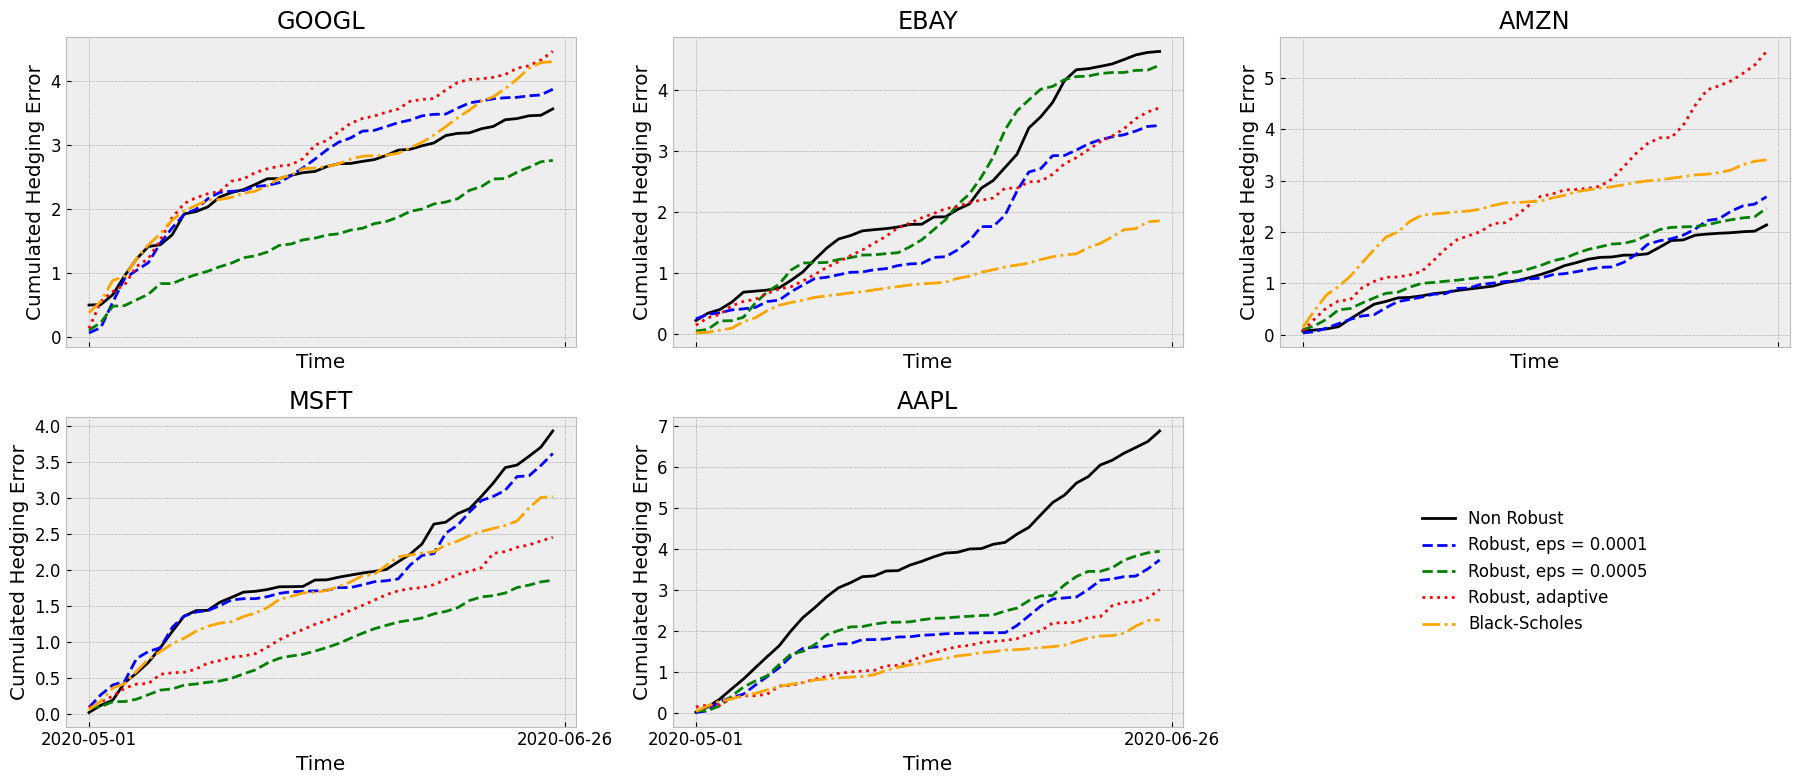

In [62]:
# Define the number of stocks
num_stocks = len(stocks)

# Determine the number of rows and columns for the subplots
num_cols = (num_stocks + 1) // 2  # Distribute stocks into two rows
num_rows = 2 if num_stocks > 1 else 1


# Create subplots and adjust the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6* num_cols, 4 * num_rows), sharex=True)

# Flatten axes for easier iteration, but keep the 2D shape for positioning the legend
axes = np.array(axes).reshape(num_rows, num_cols)

plt.subplots_adjust(left=0.1)  # Adjust left margin to make space

# Variable to store the handles and labels for the legend
handles, labels = [], []

# Iterate through stocks and plot them in the subplots
for idx, (ax, s) in enumerate(zip(axes.flatten(), stocks)):
    ax.set_title(f"{s}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated Hedging Error")
    line1, = ax.plot(np.cumsum(Rewards_3_dict[s]), color="black", label="Non Robust")
    line2, = ax.plot(np.cumsum(Rewards_robust_3_dict[s]), color="blue", label="Robust, eps = 0.0001", linestyle="dashed")
    line3, = ax.plot(np.cumsum(Rewards_robust_32_dict[s]), color="green", label="Robust, eps = 0.0005", linestyle="dashed")
    line4, = ax.plot(np.cumsum(Rewards_robust_adaptive_3_dict[s]), color="red", label="Robust, adaptive", linestyle="dotted")
    line5, = ax.plot(np.cumsum(Rewards_BS_3_dict[s]), color="orange", label="Black-Scholes", linestyle="dashdot")
    
    # Store handles and labels only once
    if not handles and not labels:
        handles.extend([line1, line2, line3, line4,line5])
        labels.extend([line.get_label() for line in [line1, line2, line3, line4,line5]])

    xtick_numbers_test2 = [0, len(Rewards_3_dict[s])]
    ax.set_xticks(xtick_numbers_test2)
    ax.set_xticklabels([
        S_test2["Date"].dt.date.iloc[xtick_numbers_test2[0]+T+1],
        S_test2["Date"].dt.date.iloc[xtick_numbers_test2[1] +T]
    ])

    ax.grid(True)

# Place the legend in the last subplot of the second row
legend_ax = axes[-1, -1]  # Last column of the second row
legend_ax.axis('off')  # Hide the axes
legend_ax.legend(handles, labels, loc='center', frameon=False)  # Place legend in center



# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 1])  # Ensure the main plot area is optimized
plt.savefig('test2.pdf', format='pdf')
plt.show()


Overall Statistics

In [59]:
df_all_3 = df_combined_3.reset_index()
df_all_3.describe()

,Index,Non-Robust,"Robust, eps = 0.0001","Robust, eps = 0.0005",Robust adaptive,Black-Scholes
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,19.500000,0.105748,0.086641,0.077190,0.095769,0.074232
std,11.572364,0.094297,0.083385,0.071865,0.074109,0.066325
min,0.000000,0.001311,0.000477,0.000114,0.000100,0.007164
25%,9.750000,0.028931,0.023676,0.026916,0.042427,0.027931
50%,19.500000,0.076096,0.057876,0.056943,0.077963,0.051346
75%,29.250000,0.153045,0.121833,0.099093,0.125751,0.102054
max,39.000000,0.497285,0.396066,0.447594,0.422036,0.376812


# Histogram

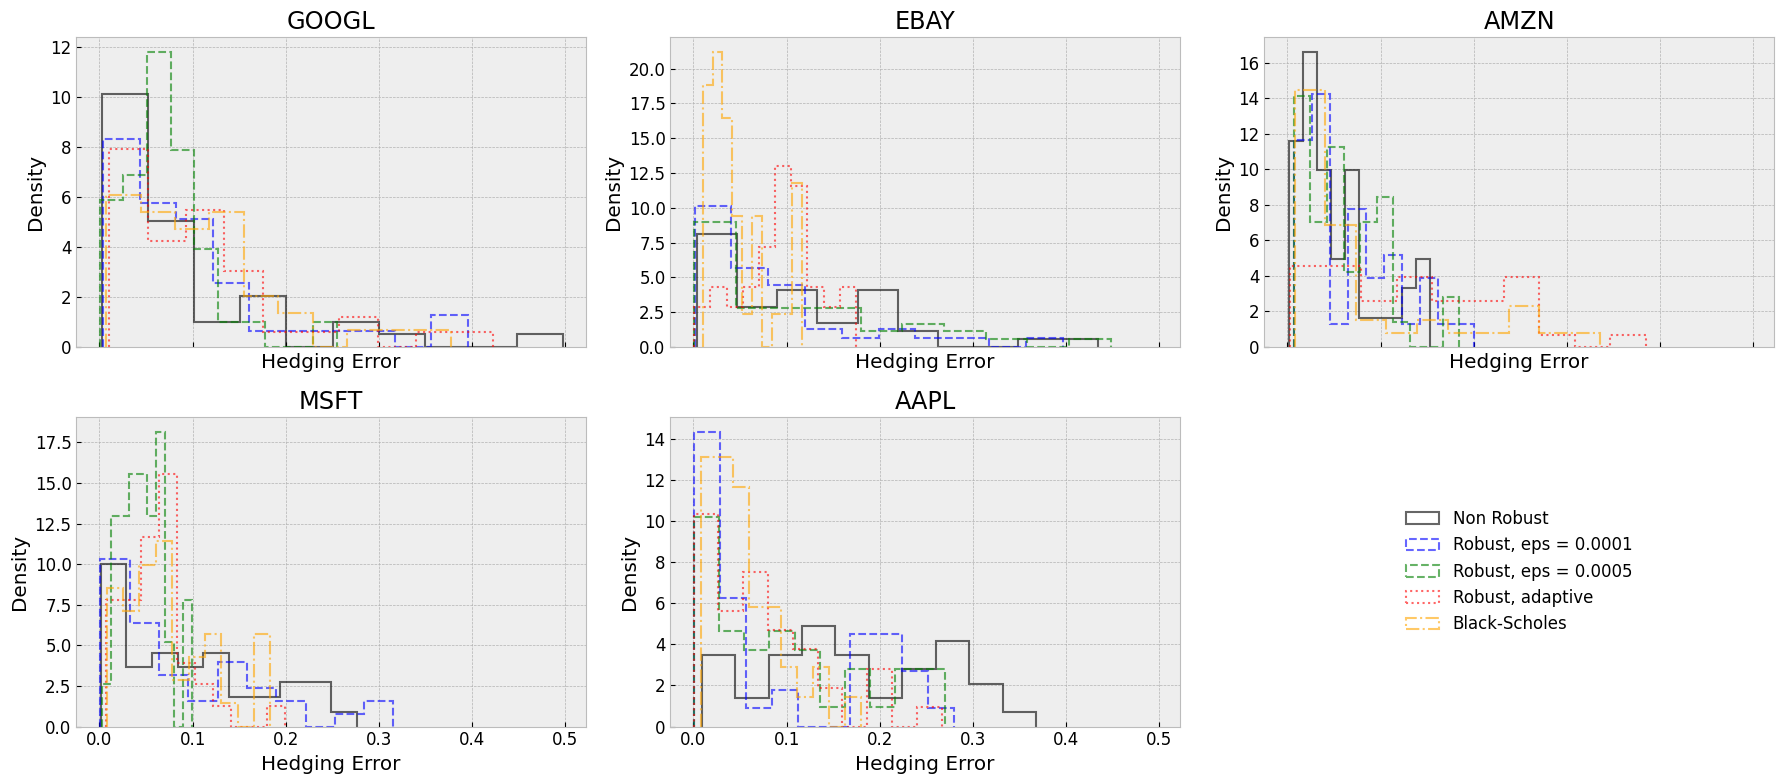

In [60]:
# Define the number of stocks
num_stocks = len(stocks)

# Determine the number of rows and columns for the subplots
num_cols = (num_stocks + 1) // 2  # Distribute stocks into two rows
num_rows = 2 if num_stocks > 1 else 1

# Create subplots and adjust the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows), sharex=True)

# Flatten axes for easier iteration, but keep the 2D shape for positioning the legend
axes = np.array(axes).reshape(num_rows, num_cols)

plt.subplots_adjust(left=0.1)

# Iterate through stocks and plot them in the subplots
for idx, (ax, s) in enumerate(zip(axes.flatten(), stocks)):
    ax.set_title(f"{s}")
    ax.set_xlabel("Hedging Error")
    ax.set_ylabel("Density")
    h1 = ax.hist(Rewards_3_dict[s], color="black", histtype='step', linewidth=1.5,label="Non Robust", alpha=0.6, density=True)
    h2 = ax.hist(Rewards_robust_3_dict[s], color="blue", histtype='step', linewidth=1.5,label="Robust, eps = 0.0001", linestyle="dashed", alpha=0.6, density=True)
    h3 = ax.hist(Rewards_robust_32_dict[s], color="green", histtype='step', linewidth=1.5, label="Robust, eps = 0.0005", linestyle="dashed", alpha=0.6, density=True)
    h4 = ax.hist(Rewards_robust_adaptive_3_dict[s], color="red", histtype='step', linewidth=1.5, label="Robust, adaptive", linestyle="dotted", alpha=0.6, density=True)
    h5 = ax.hist(Rewards_BS_3_dict[s], color="orange", histtype='step', linewidth=1.5, label="Black-Scholes", linestyle="dashdot", alpha=0.6, density=True)
    ax.grid(True)

# Collect handles and labels from any subplot (e.g., first)
handles, labels = axes[0, 0].get_legend_handles_labels()

# Determine the subplot location for the legend: second row, third column
# Ensure there are enough columns
if num_rows >= 2 and num_cols >= 3:
    legend_ax = axes[1, 2]
else:
    legend_ax = axes[-1, -1]  # fallback: last subplot

legend_ax.axis('off')
legend_ax.legend(handles, labels, loc='center', frameon=False)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('histogram_test2.pdf', format='pdf')
plt.show()
